In [1]:
%cd ..


/tempory/NeuralNetworksDIY


In [8]:
import os, pickle
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from skimage import io, transform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.linear import Linear
from src.loss import *
from src.activation import TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, LeakyReLU, Softplus
from src.encapsulation import Sequential, Optim

np.random.seed(42)


jouer avec les hpyerparam
espace latent
les initialisation 
plein de loss 
qu'est ce qui boost les perfs 

# Débruitage d'image plus petite

fashion mnist

In [3]:
def load_data(rootdir, class_list=None, trim: float = 0.5):
    def normalize_batch_image(X):
        mn = np.min(X)
        mx = np.max(X)
        X_norm = (X - mn) * (1.0 / (mx - mn))
        return X_norm

    train = pd.read_csv(os.path.join(rootdir, "fashion-mnist_train.csv"))
    # Filtering requested class
    if class_list:
        train = train[train["label"].isin(class_list)]
    y_train = train["label"].values
    X_train = train.drop(columns="label").values

    test = pd.read_csv(os.path.join(rootdir, "fashion-mnist_test.csv"))
    # Filtering requested class
    if class_list:
        test = test[test["label"].isin(class_list)]
    y_test = test["label"].values
    X_test = test.drop(columns="label").values

    trim_train = int(len(X_train) * trim)
    # trim_test = int(len(X_test) * trim)
    trim_test = int(len(X_test))

    # Normalization + trimming
    X_train = normalize_batch_image(X_train[:trim_train, :])
    X_test = normalize_batch_image(X_test[:trim_test, :])
    y_train = y_train[:trim_train]
    y_test = y_test[:trim_test]

    return (X_train, X_test, y_train, y_test)


rootdir = "./data/fashion-mnist/"
X_train, X_test, y_train, y_test = load_data(rootdir, [0], trim=0.5)

y_train_oh = OneHotEncoder().fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_oh = OneHotEncoder().fit_transform(y_test.reshape(-1, 1)).toarray()
nb_class = y_train_oh.shape[1]
batch_size = 64


reconstruction simple 

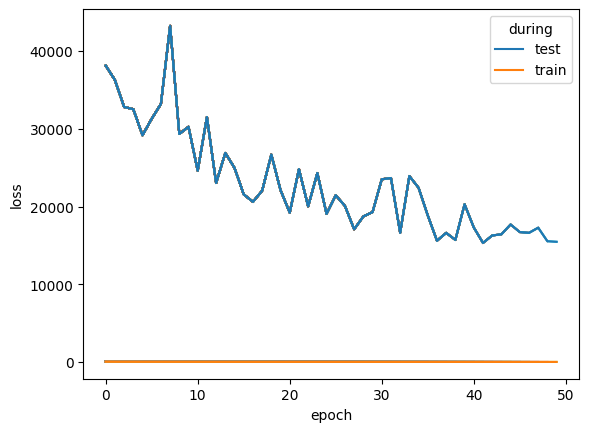

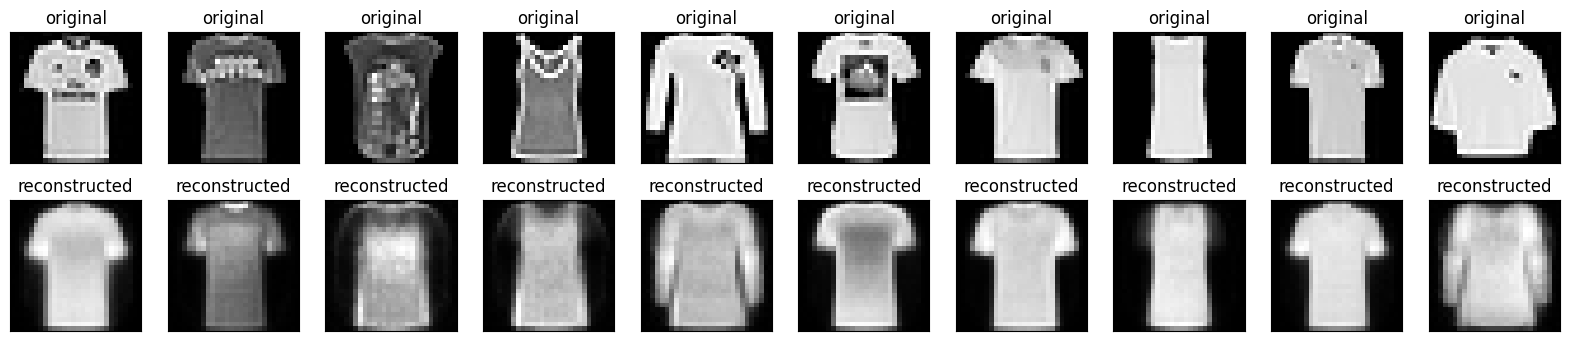

In [4]:
fig, ax = plt.subplots()

encoder = [
    Linear(784, 64, init_type="xavier_uniform"),
    TanH(),
]
decoder = [
    Linear(64, 784, init_type="xavier_uniform"),
    Sigmoid()
]
net = Sequential(*(encoder + decoder))
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
result_df = optimizer.SGD_eval(
    X_train,
    X_train,
    batch_size,
    50,
    test_size=0.33,
    return_dataframe=True,
    online_plot=True,
)

loss_long_df = pd.melt(
    result_df,
    id_vars="epoch",
    value_vars=["loss_test", "loss_train"],
    value_name="loss",
    var_name="during",
).replace({"loss_test": "test", "loss_train": "train"})
sns.lineplot(data=loss_long_df, x="epoch", y="loss", hue="during", ax=ax)

n = 10
decoded_imgs = net.forward(X_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Reconstruction par epoch

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

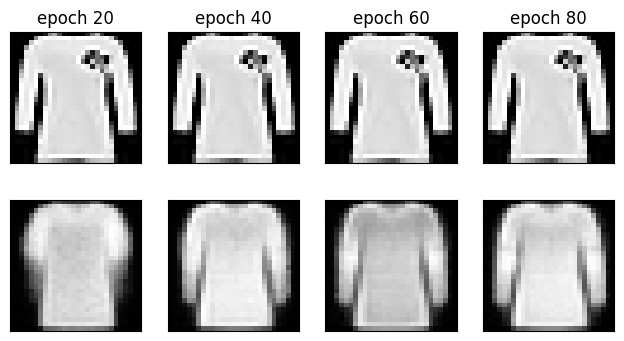

In [5]:
plt.figure(figsize=(20, 4))
optimizer.network.reset()
n = 10
for i in range(n):
    optimizer.SGD(
        X_train,
        X_train,
        batch_size,
        20,
    )
    decoded_imgs = optimizer.network.forward(X_test)

    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[4].reshape(28, 28))
    plt.title(f"epoch {(i+1)*20}")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[4].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('reports/reconstruction_per_epoch.pdf', dpi=600)

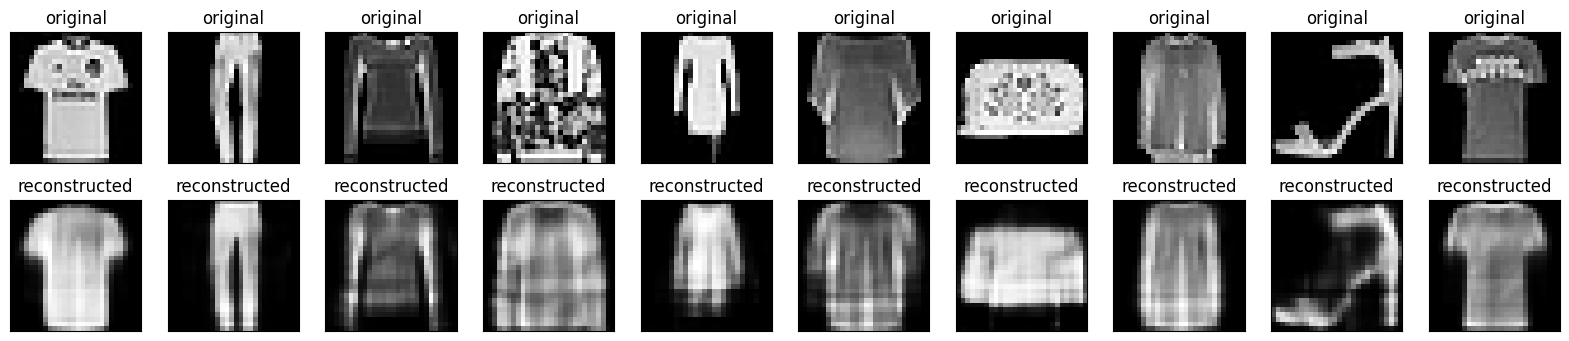

In [ ]:
X_train, X_test, y_train, y_test = load_data(rootdir, trim=0.5)
optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
optimizer.network.reset()
optimizer.SGD(
    X_train,
    X_train,
    batch_size,
    1000,
)

n = 10
decoded_imgs = net.forward(X_test)
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()
fig.savefig('reports/reconstruction_all_class.pdf', dpi=600)


In [ ]:
with open("./notebooks/fashion-mnist_1000_epoch.pkl", "wb") as f:
    pickle.dump(optimizer.network, f)


In [ ]:
with open("./notebooks/fashion-mnist_1000_epoch.pkl", "rb") as f:
    test = pickle.load(f)


In [ ]:
test


Does the middle activation funct impact reconstruction performance ? 

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch:   0%|          | 0/50 [00:00<?, ?it/s]

Batch:   0%|          | 0/31 [00:00<?, ?it/s]

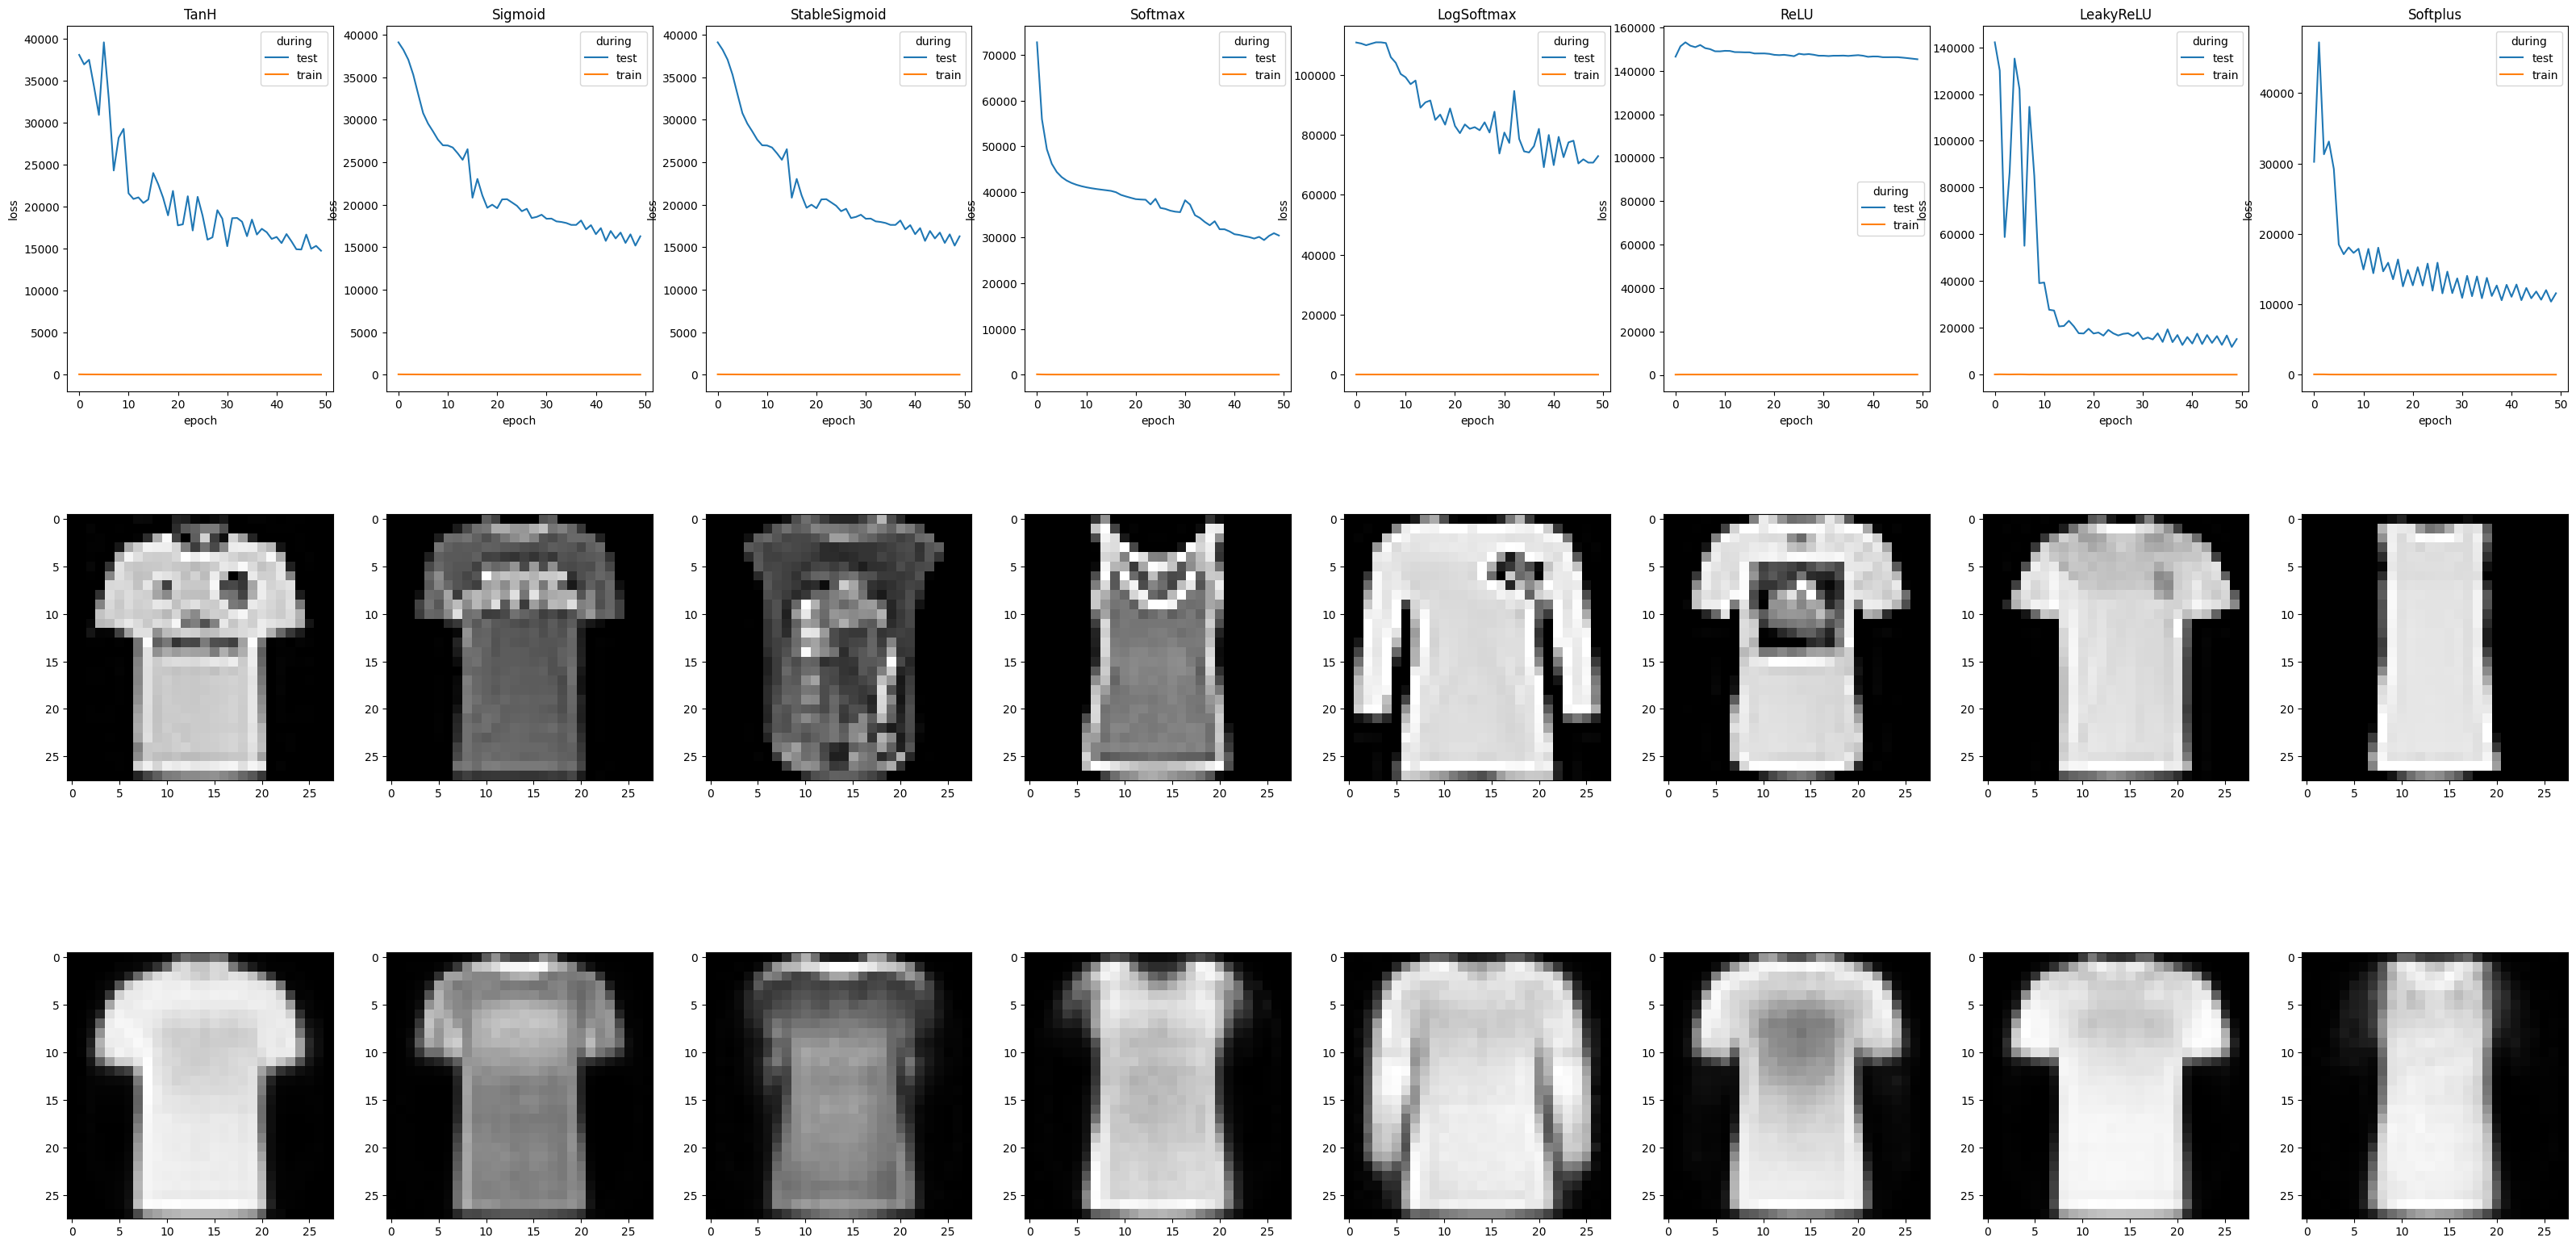

In [11]:
fig, ax = plt.subplots(ncols=8, nrows=3, figsize=(40, 20))

for i, act_func in enumerate([TanH, Sigmoid, StableSigmoid, Softmax, LogSoftmax, ReLU, LeakyReLU, Softplus]):
    try:
        ax_col = ax[:, i]
        ax_col[0].set_title(act_func.__name__)
        
        encoder = [
            Linear(784, 64, init_type="xavier_uniform"),
            act_func(),
        ]
        decoder = [
            Linear(64, 784, init_type="xavier_uniform"),
            Sigmoid()
        ]
        net = Sequential(*(encoder + decoder))
        optimizer = Optim(net.reset(), MSELoss(), eps=1e-3)
        result_df = optimizer.SGD_eval(
            X_train,
            X_train,
            batch_size,
            50,
            test_size=0.33,
            return_dataframe=True,
        )

        loss_long_df = pd.melt(result_df, id_vars='epoch', value_vars=['loss_test', 'loss_train'], value_name='loss', var_name='during').replace({'loss_test': 'test', 'loss_train': 'train'})
        sns.lineplot(loss_long_df, x='epoch', y='loss', hue='during', ax=ax_col[0])
        # display original
        ax_col[1].imshow(X_test[i].reshape(28, 28), cmap='gist_gray')
        # ax_col[1].set_title("original")
        # ax_col[1].get_xaxis().set_visible(False)
        # ax_col[1].get_yaxis().set_visible(False)

        # display reconstruction
        ax_col[2].imshow(decoded_imgs[i].reshape(28, 28), cmap='gist_gray')
        # ax_col[2].set_title("reconstructed")
        # ax_col[2].get_xaxis().set_visible(False)
        # ax_col[2].get_yaxis().set_visible(False)
    except KeyError:
        continue
fig.savefig('reports/init_type.pdf', dpi=600)

# Débruitage d'image

Dataset : https://www.kaggle.com/datasets/uurdeep/cleaning-dirty-documents-unzipped

In [6]:
def load_data(root_dir):
    size = (540, 420)
    X = []
    for filepath in os.listdir(root_dir + "/X"):
        imgpath = os.path.join(root_dir, "X", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        X.append(image)
    X = np.array(X)

    y = []
    for filepath in os.listdir(root_dir + "/y"):
        imgpath = os.path.join(root_dir, "y", filepath)
        image = io.imread(imgpath)
        image = transform.resize(image, size).flatten()
        y.append(image)
    y = np.array(y)

    return X, y


X, y = load_data("./data/dirty_documents")
print(X.shape)
print(y.shape)


(144, 226800)
(144, 226800)


In [7]:
from src.convolution import *

encoder = [Conv1D(3, 1, 16, stride=2), TanH(), Conv1D(3, 1, 8, stride=2), TanH()]

decoder = [
    Conv1D(3, 1, 8, stride=2),
    TanH(),
    Conv1D(3, 1, 16, 2),
    TanH(),
    Conv1D(3, 1, 1),
    Sigmoid(),
]


net = Sequential(*(encoder + decoder))
optimizer = Optim(net, MSELoss(), eps=1e-1)
lossList = optimizer.SGD(X[:, :, np.newaxis], y, 144, 10)
print(lossList)
pd.Series(lossList).plot()


  0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: 

In [ ]:
batch_size = 32
d = 2  # Dim des entrées

X = np.random.random(size=(256, d))
y = np.random.choice([1], size=(256, 1))

encoder = [
    Linear(226800, 226800 // 8),
    TanH(),
    Linear(226800 // 8, 226800 / 16),
    TanH(),
    Linear(226800 / 16, 226800 / 32),
    TanH(),
]
decoder = [
    Linear(226800 / 16, 226800 / 32),
    TanH(),
    Linear(226800 / 8, 226800 / 16),
    TanH(),
    Linear(226800, 226800 / 8),
    Sigmoid(),
]
net = encoder + decoder
optimizer = Optim(net, CrossEntropyLoss(), eps=1e-1)
lossList = optimizer.SGD(X, y, batch_size, 10)
print(lossList)
pd.Series(lossList).plot()


In [ ]:
X.shape


**A faire avec une convolution**